In [48]:
import numpy as np
import pandas as pd

# Evaludate CI On Trained Survival Model

In [49]:
data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")

In [50]:
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

def negative_log_partial_likelihood(censor, risk):
    """Return the negative log-partial likelihood of the prediction
    y_true contains the survival time
    risk is the risk output from the neural network
    censor is the vector of inputs that are censored
    regularization is the regularization constant (not used currently in model)

    Uses the Keras backend to perform calculations

    Sorts the surv_time by sorted reverse time
    """

    # calculate negative log likelihood from estimated risk
    epsilon = 0.001
    risk = K.reshape(risk, [-1])  # flatten
    hazard_ratio = K.exp(risk)

    # cumsum on sorted surv time accounts for concordance
    log_risk = K.log(tf.cumsum(hazard_ratio)+epsilon)
    log_risk = K.reshape(log_risk, [-1])
    uncensored_likelihood = risk - log_risk

    # apply censor mask: 1 - dead, 0 - censor
    censored_likelihood = uncensored_likelihood * censor
    num_observed_events = K.sum(censor)
    neg_likelihood = - K.sum(censored_likelihood) / \
        tf.cast(num_observed_events, tf.float32)

    return neg_likelihood

In [51]:
from lifelines.utils import concordance_index

def concordance_metric(survival_time, predicted_risk, censor):
    # calculate the concordance index
    epsilon = 0.001
    partial_hazard = np.exp(-(predicted_risk+epsilon)).flatten()
    censor = censor.astype(int)
    ci = concordance_index(survival_time, partial_hazard, censor)
    return ci

OS = clinical[['OS']].values.flatten()
event = clinical[['Event']].values.flatten()

In [52]:
import glob
files = glob.glob("/home/pzs2/capstone/models/surv_immune_xfer_10_27__00_29/surv/*.hdf5")

In [53]:
cis = []

# for hdf5 in files:
#     surv_model = load_model(hdf5, custom_objects={
#                                             'negative_log_partial_likelihood': negative_log_partial_likelihood})
#     predictions = surv_model.predict(data)
#     ci = concordance_metric(OS, np.exp(predictions), event)
#     print("File: {}, CI: {}".format(hdf5, ci))
#     cis.append([hdf5, ci])

# Transfer Learning

## Just On Survival

In [264]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")

labels = clinical[['Event']].values
data = data.values

sm = SMOTE()
X, y = sm.fit_sample(data, labels.ravel())


x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y)
y_train_cat = np.append(y_train_res.reshape([-1,1]), np.abs(y_train_res - 1).reshape([-1,1]), axis=1)
y_val_cat = np.append(y_val_res.reshape([-1,1]), np.abs(y_val_res - 1).reshape([-1,1]), axis=1)

In [158]:
from keras.models import Sequential, Model
import keras.layers as layers

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/surv_immune_xfer_10_27__11_05/surv/checkpoint.0290.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()
xfer_model = surv_model

xfer_model.add(layers.Dense(1, activation="sigmoid", name="xfer_output"))

# freeze all the layers before the output layer
for layer in xfer_model.layers[0:-2]:
    layer.trainable = False

xfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               137856    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [154]:
from keras.optimizers import Adam

opt = Adam(lr=3e-3)

xfer_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

xfer_model.fit(x_train_res, y_train_res,
          batch_size=64,
          epochs=20,
          validation_data=(x_val_res, y_val_res))



278/278 [==============================] - 3s 12ms/step


[836298.0103417266, 0.3381294972604985]

In [156]:
xfer_model.evaluate(x=x_val_res, y=y_val_res)

94/94 [==============================] - 0s 196us/step


[978122.4867021276, 0.4999999936590803]

# Predicting with PD-1 / PD-L1 Layer

In [286]:
from keras.models import Sequential, Model
import keras.layers as layers
from keras.optimizers import Adam

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/surv_immune_xfer_10_27__11_05/immune/genes.hdf5")

# taking out the last layer layers
# surv_model.pop()
xfer_model = surv_model

xfer_model.add(layers.Dense(1, activation="sigmoid", name="xfer_output"))

# freeze all the layers before the output layer
for layer in xfer_model.layers[0:-2]:
    layer.trainable = False

opt = Adam(lr=0.0005)

xfer_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

xfer_model.fit(x_train, 
               y_train,
                batch_size=64,
                epochs=100,
                validation_data=(x_val, y_val),
                verbose=1)

Train on 417 samples, validate on 47 samples
Epoch 1/100
417/417 [==============================] - 11s 25ms/step - loss: 1025138.2203 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 2/100
417/417 [==============================] - 0s 74us/step - loss: 1034927.7941 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 3/100
417/417 [==============================] - 0s 67us/step - loss: 1026063.7488 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 4/100
417/417 [==============================] - 0s 67us/step - loss: 1049516.0843 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 5/100
417/417 [==============================] - 0s 67us/step - loss: 1040765.0227 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 6/100
417/417 [==============================] - 0s 67us/step - loss: 1035591.3411 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 7/100
417/417 [==============================] - 0s 67us/step - loss: 10

417/417 [==============================] - 0s 69us/step - loss: 1049592.6323 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 57/100
417/417 [==============================] - 0s 68us/step - loss: 1050356.2032 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 58/100
417/417 [==============================] - 0s 68us/step - loss: 1046842.2374 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 59/100
417/417 [==============================] - 0s 67us/step - loss: 1043260.8611 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 60/100
417/417 [==============================] - 0s 68us/step - loss: 1018605.5106 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 61/100
417/417 [==============================] - 0s 68us/step - loss: 1038261.9368 - acc: 0.5012 - val_loss: 1152805.1250 - val_acc: 0.4894
Epoch 62/100
417/417 [==============================] - 0s 67us/step - loss: 1030813.5653 - acc: 0.5012 - val_loss: 1152805.1250 - 

In [287]:
xfer_model.layers[0:-2]

In [288]:
xfer_model.evaluate(x=x_val, y=y_val)

47/47 [==============================] - 0s 151us/step


[677845.4235372341, 0.48936170402993545]

In [289]:
predicted_events = np.round(xfer_model.predict(x_val)).flatten()
predicted_events

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [290]:
xfer_model.pop()
xfer_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
xfer_model.predict(x_val)

array([[ 150.1755  ,  131.53067 ],
       [ 236.24246 ,  215.07982 ],
       [ 144.75847 ,  123.872116],
       [ 125.11591 ,  106.58049 ],
       [ 342.59528 ,  302.34528 ],
       [  70.58555 ,   62.88681 ],
       [1846.0403  , 1473.4915  ],
       [ 187.37807 ,  158.80504 ],
       [ 240.12025 ,  211.4128  ],
       [ 342.88898 ,  290.83832 ],
       [ 193.12936 ,  178.25209 ],
       [  62.663624,   54.91398 ],
       [ 160.16026 ,  136.14574 ],
       [ 492.88757 ,  425.6036  ],
       [ 159.37471 ,  135.8893  ],
       [ 214.8987  ,  181.02892 ],
       [ 169.23286 ,  149.46318 ],
       [ 708.2363  ,  591.8416  ],
       [ 110.92498 ,   95.38008 ],
       [  73.29873 ,   63.73777 ],
       [ 226.62376 ,  187.15771 ],
       [ 107.92126 ,   93.39476 ],
       [ 117.25953 ,   98.2668  ],
       [ 112.48241 ,   96.031876],
       [ 178.85522 ,  160.47733 ],
       [ 151.7131  ,  130.17383 ],
       [  83.53391 ,   83.64165 ],
       [  55.949593,   50.670296],
       [ 158.04086 ,

# t-SNE Visualization

## Visualizing Survival Layer

In [292]:
cancertypes = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/cancer.type.train.txt").iloc[:,0]
data = pd.read_csv("/home/pzs2/capstone/proj/TCGA_processed/pancancer_all_immune/TrainingData.txt", sep="\t")

cancertypes = cancertypes.astype('category')
cancer_categories = cancertypes.astype('category').cat.categories

In [293]:
import random

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = []

for i in range(0,len(cancer_categories)):
  colors.append(generate_new_color(colors,pastel_factor = 0.9))

### Unnormalized Model

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8652 samples in 0.038s...
[t-SNE] Computed neighbors for 8652 samples in 0.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8652
[t-SNE] Computed conditional probabilities for sample 2000 / 8652
[t-SNE] Computed conditional probabilities for sample 3000 / 8652
[t-SNE] Computed conditional probabilities for sample 4000 / 8652
[t-SNE] Computed conditional probabilities for sample 5000 / 8652
[t-SNE] Computed conditional probabilities for sample 6000 / 8652
[t-SNE] Computed conditional probabilities for sample 7000 / 8652
[t-SNE] Computed conditional probabilities for sample 8000 / 8652
[t-SNE] Computed conditional probabilities for sample 8652 / 8652
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.523506
[t-SNE] KL divergence after 5000 iterations: 1.272086


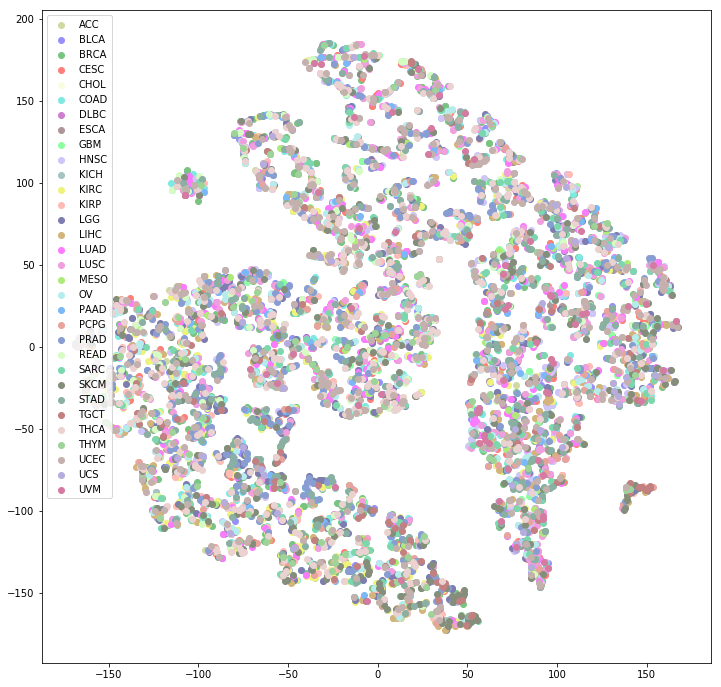

In [294]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/no_norm_10_27__17_27/surv.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()

predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=5000) # reduce perplexity?
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

### Normalized Model

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8652 samples in 0.009s...
[t-SNE] Computed neighbors for 8652 samples in 0.915s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8652
[t-SNE] Computed conditional probabilities for sample 2000 / 8652
[t-SNE] Computed conditional probabilities for sample 3000 / 8652
[t-SNE] Computed conditional probabilities for sample 4000 / 8652
[t-SNE] Computed conditional probabilities for sample 5000 / 8652
[t-SNE] Computed conditional probabilities for sample 6000 / 8652
[t-SNE] Computed conditional probabilities for sample 7000 / 8652
[t-SNE] Computed conditional probabilities for sample 8000 / 8652
[t-SNE] Computed conditional probabilities for sample 8652 / 8652
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.229095
[t-SNE] KL divergence after 5000 iterations: 1.482774


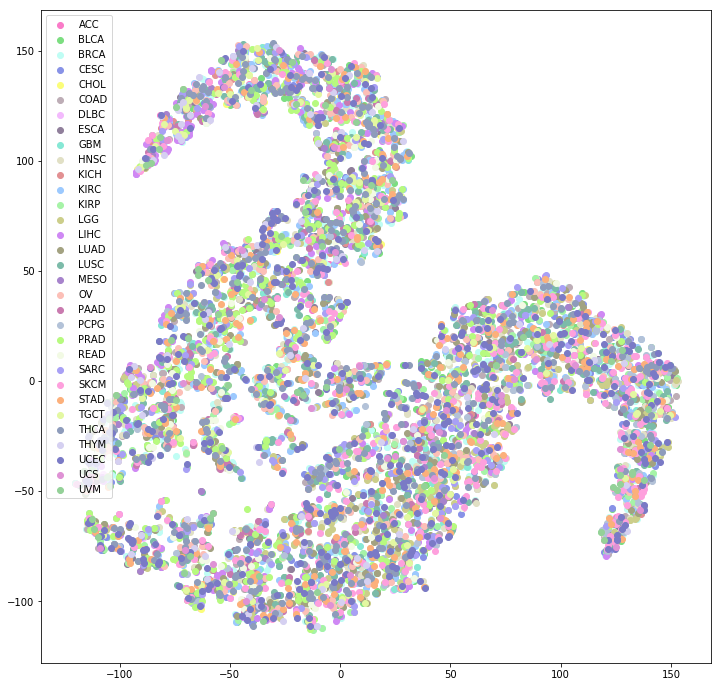

In [196]:
from keras.models import Sequential, Model, load_model
import keras.layers as layers

from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

surv_model = Sequential()
surv_model = load_model("/home/pzs2/capstone/models/surv_immune_xfer_10_27__00_29/surv/checkpoint.0350.hdf5", custom_objects={
                                            'negative_log_partial_likelihood': negative_log_partial_likelihood})

# taking out the last layer layers
surv_model.pop()


predictions_type = surv_model.predict(data)

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=5000)
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(12, 12))
for i, c in zip(cancer_categories, colors, ):
    plt.scatter(tsne_results[cancertypes == i, 0], tsne_results[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()

## Visualizing Genentech Survival

In [201]:
data = pd.read_csv("/home/pzs2/capstone/proj/risk/visualization/TCGA/data/genentech_processed.tsv", sep="\t")
clinical = pd.read_csv("./data/genentech_processed.labels.tsv", sep="\t")
event = clinical[['Event']].values.flatten()

In [202]:
xfer_model.pop()

opt = Adam(lr=3e-5)

xfer_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 348 samples in 0.000s...
[t-SNE] Computed neighbors for 348 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 348 / 348
[t-SNE] Mean sigma: 15.606998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.394257
[t-SNE] KL divergence after 5000 iterations: 1.034538


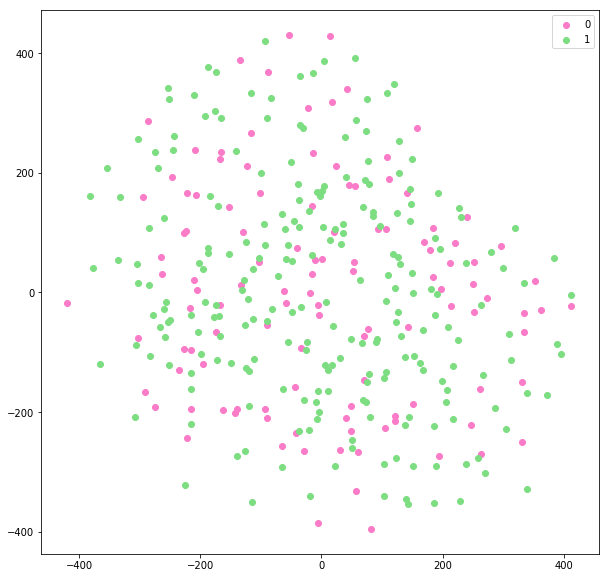

In [218]:
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.manifold import TSNE

predictions_type = xfer_model.predict(data)

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(predictions_type)

plt.figure(figsize=(10, 10))
for i, c in zip([0,1], colors):
    plt.scatter(tsne_results[event == i, 0], tsne_results[event == i, 1], c=c, label=i)
plt.legend()
plt.show()

In [206]:
predictions_type[1:10,:]

array([[ 323.51254 ,   99.57052 ],
       [1526.8995  ,  426.94363 ],
       [ 230.0979  ,   71.79101 ],
       [ 321.59525 ,   88.84458 ],
       [ 146.6547  ,   47.022232],
       [ 159.78004 ,   50.043377],
       [ 215.0129  ,   62.557842],
       [ 137.90654 ,   40.51508 ],
       [ 179.9356  ,   50.99004 ]], dtype=float32)

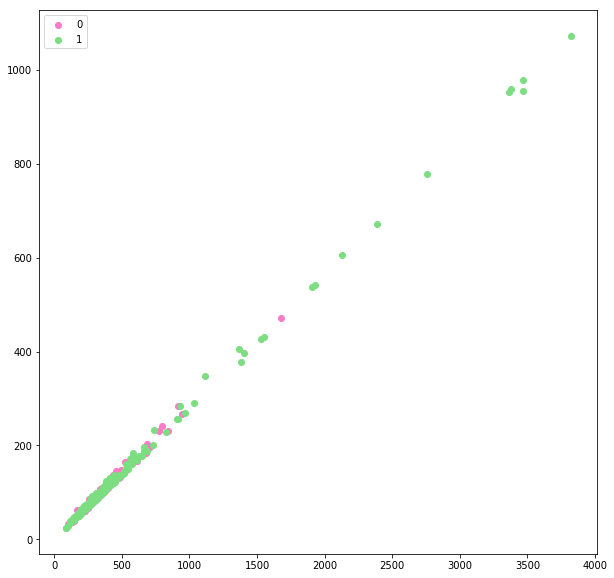

In [219]:
plt.figure(figsize=(10, 10))
for i, c in zip([0,1], colors):
    plt.scatter(predictions_type[event == i, 0], predictions_type[event == i, 1], c=c, label=i)
plt.legend()
plt.show()

In [89]:
tsne_results2 = tsne_results

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

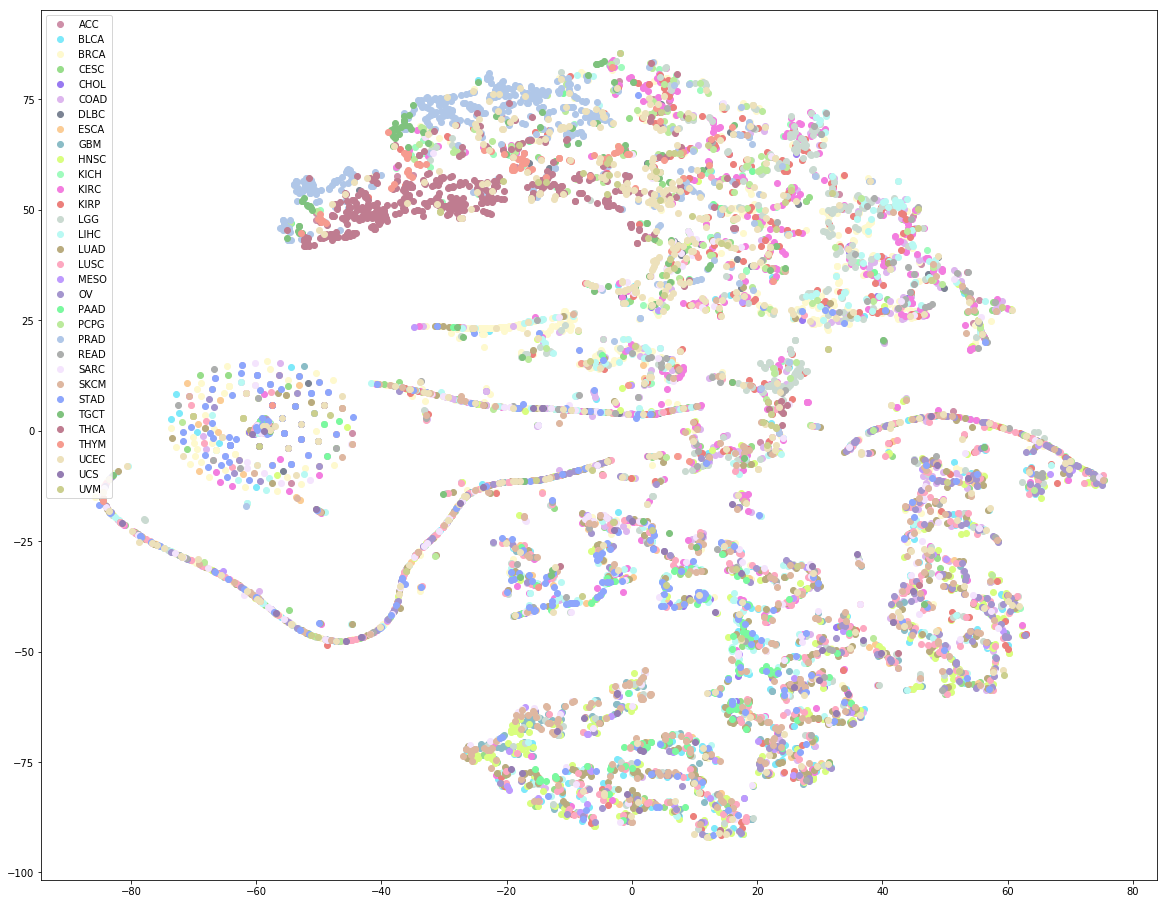

In [102]:
fig = plt.figure(figsize=(20, 16))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c in zip(cancer_categories, colors):
    plt.scatter(tsne_results2[cancertypes == i, 0], tsne_results2[cancertypes == i, 1], c=c, label=i)
plt.legend()
plt.show()
fig.savefig("tsne_cancertypes")

In [107]:
tsne_results_pd = pd.DataFrame(tsne_results2)
tsne_results_pd.to_csv("tsne_output.csv")